<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Figures/Score_1brkpt_TESTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
%reset -f

### Imports

In [ ]:
!pip install rioxarray
!pip install torchmetrics


In [38]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
X = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 16, 17]])
#X = np.array([[1, 4, 7, 1], [2, 1, 8, 11], [3, 6, 1, 12]])
#mask = iso == 1
#X = np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]])
print(X)
print(X.transpose())
print(np.rot90(X))


[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 16 17]]
[[ 1  5  9 13]
 [ 2  6 10 14]
 [ 3  7 11 16]
 [ 4  8 12 17]]
[[ 4  8 12 17]
 [ 3  7 11 16]
 [ 2  6 10 14]
 [ 1  5  9 13]]


### Dunn score/No breakpoint

(1281, 2042)
Dunn Index: 0.29697074680018204
Dunn Index: 0.31234353467574455
Dunn Index: 0.2200004267880201
Dunn Index: 0.2003409221286743
Dunn Index: 0.15777692395719103
Dunn Index: 0.18013546971724256
Dunn Index: 0.16701238797201026
Dunn Index: 0.1442188040825953
Dunn Index: 0.1327295580739909
Dunn Index: 0.151839641403046
Dunn Index: 0.16760388352176722
Dunn Index: 0.1315133230975077
Dunn Index: 0.14502531274147146
Dunn Index: 0.12721858347852907
Dunn Index: 0.14476926805453733


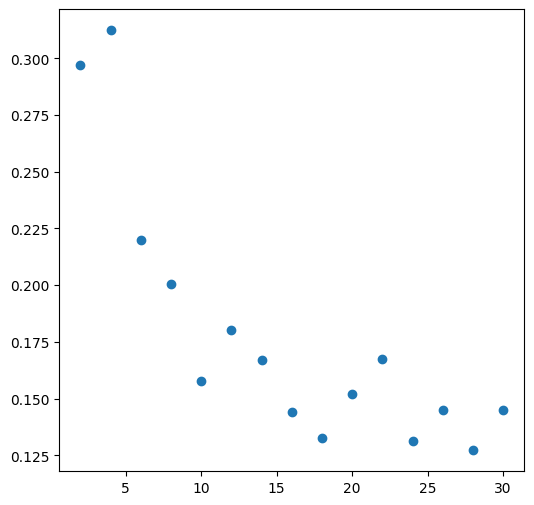

In [13]:
import torch
from torchmetrics.clustering import DunnIndex
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rioxarray as rx
import os

dunn_index = DunnIndex(p=2)


isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()
  X = torch.tensor(X.astype(float))

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  cluster_labels = torch.tensor(cluster_labels.astype(float))
  score = dunn_index(X, cluster_labels)
  test_scores.append(score)

  print(f"Dunn Index: {score.item()}")



fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)




###Dunn scores/One breakpoint

Optimal breakpoint 1: 10.222222222222221


/tmp/ipython-input-1452934405.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


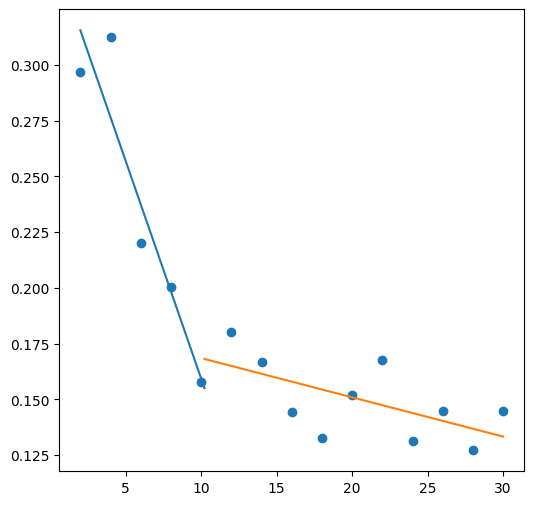

In [15]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Silhouette score/No breakpoint

(1281, 2042)
Silhouette score: 0.21976770817049426
Silhouette score: 0.21354694985132047
Silhouette score: 0.16121200214392184
Silhouette score: 0.16532466438765722
Silhouette score: 0.1469203445004423
Silhouette score: 0.14458892584442665
Silhouette score: 0.13504321928308075
Silhouette score: 0.12671725024383887
Silhouette score: 0.1257663921045904
Silhouette score: 0.11809453778159919
Silhouette score: 0.13444763838974055
Silhouette score: 0.11526039532884413
Silhouette score: 0.11749316530449021
Silhouette score: 0.11877916658892383
Silhouette score: 0.12095772490291412


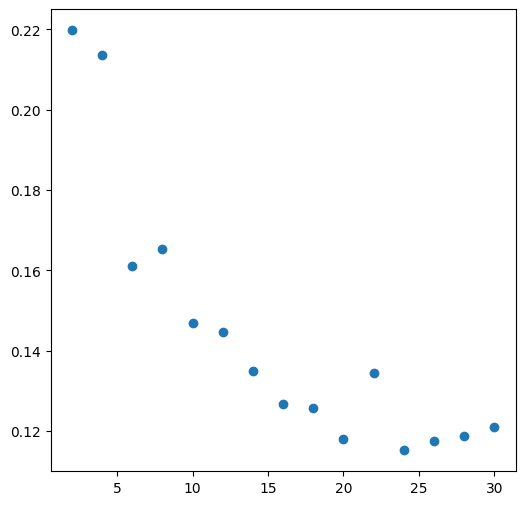

In [20]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rioxarray as rx
import os

isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)


test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)

  print(f"Silhouette score: {avg_score}")


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)




###Silhouette score/One breakpoint

Optimal breakpoint 1: 8.222222222222221


/tmp/ipython-input-1452934405.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


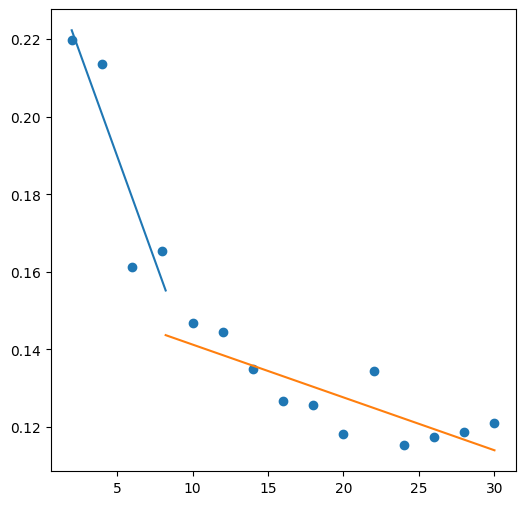

In [21]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params


x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Davies-Bouldin score/No breakpoint

(1281, 2042)
Davies Bouldin Index: 1.6446426492483763
Davies Bouldin Index: 1.4380084486704776
Davies Bouldin Index: 1.6296086845541327
Davies Bouldin Index: 1.5504116252014617
Davies Bouldin Index: 1.7048773476649597
Davies Bouldin Index: 1.742543800592248
Davies Bouldin Index: 1.743913738425386
Davies Bouldin Index: 1.741963883212906
Davies Bouldin Index: 1.7272458207949986
Davies Bouldin Index: 1.7243466356548047
Davies Bouldin Index: 1.669304421878911
Davies Bouldin Index: 1.7167569713864144
Davies Bouldin Index: 1.7146247310851157
Davies Bouldin Index: 1.7055199867375521
Davies Bouldin Index: 1.6858992340481114


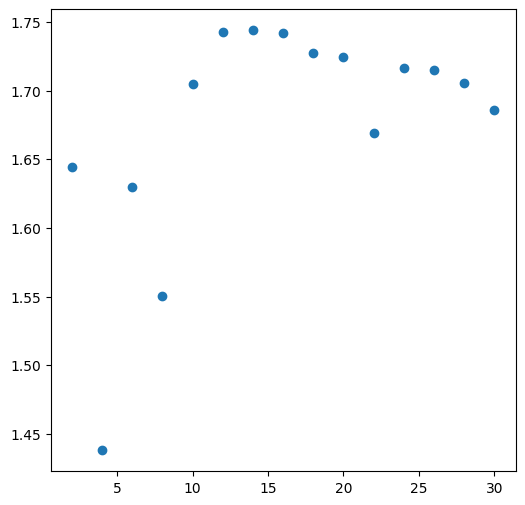

In [22]:
import torch
from torchmetrics.clustering import DunnIndex
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
import rioxarray as rx
import os


isof = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif'
pcaf = '/content/drive/My Drive/Colab Notebooks/Analogs/PCA_Test'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

iso_im = rx.open_rasterio(isof)
arr = iso_im.values
mask = (arr[0, :, :] >= 1) & (arr[0, :, :] <= 15)
print(mask.shape)

test_scores = []
#test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:

  com_im = rx.open_rasterio(os.path.join(pcaf, 'MultidimRasterLyr_d_pc_{}.tif'.format(n)))
  arr = com_im.values
  shp = com_im.values.shape
  new_arr = []
  for i in range(shp[0]):
    filtered_arr = arr[i, :, :][mask]
    new_arr.append(filtered_arr)

  X = np.array(new_arr).transpose()

  iso_im = rx.open_rasterio(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = iso_im.values
  filtered_arr = arr[0, :, :][mask]
  cluster_labels = filtered_arr
  score = davies_bouldin_score(X, cluster_labels)
  test_scores.append(score)

  print(f"Davies Bouldin Index: {score.item()}")

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)


###Davies-Bouldin score/One breakpoint

Optimal breakpoint 1: 8.222222222222221


/tmp/ipython-input-950951509.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


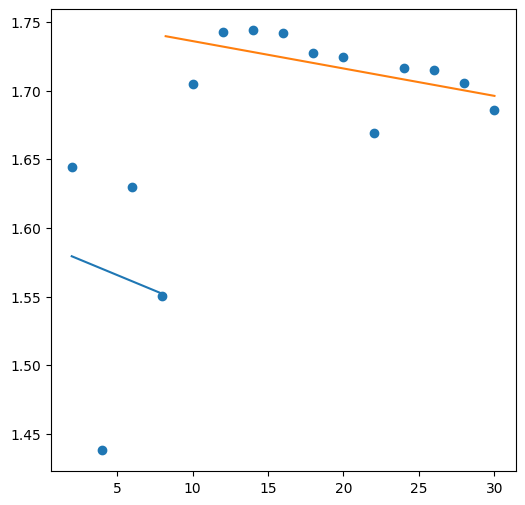

In [23]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Purity score/No breakpoint

In [39]:

'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  sum = df.iloc[:, 1:].sum().sum()
  max_values_per_row = df.iloc[:, 1:].max(axis=1)
  purity = max_values_per_row.sum()/sum
  test_scores.append(purity)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)



NameError: name 'os' is not defined

### Test

In [ ]:
!pip install permetrics

In [28]:
from permetrics import ClusteringMetric

'https://permetrics.readthedocs.io/en/latest/pages/clustering/ES.html'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

arr = df.iloc[:, 1:].to_numpy()


test_scores = []
test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
for n in test_cluster_sizes:
  y_pred, y_true = [], []
  df = pd.read_csv(os.path.join(fld, 'Zonal_eco3_{}.csv'.format(n)))
  arr = df.iloc[:, 1:].to_numpy()
  for i, row in enumerate(arr):
    for j, col in enumerate(row):
      count = arr[i, j]
      y_pred.extend([i+1]*count)
      y_true.extend([j+1]*count)
  cm = ClusteringMetric(y_true=y_true, y_pred=y_pred)
  test_scores.append(cm.purity_score())

print(len(y_true))
print(len(y_pred))
print(scores)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)


ModuleNotFoundError: No module named 'permetrics'

###Purity score/One breakpoint

Optimal breakpoint 1: 5.99999999859795


/tmp/ipython-input-950951509.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


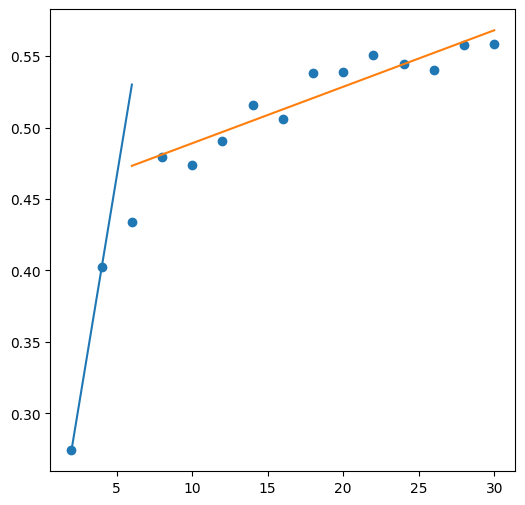

In [30]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])


###Entropy score/No breakpoint

,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,277994,72208,424,1211,107563,531,158698,15471,92041,18948,48917,0,31670,7952,123796
1,2,167052,4213,4111,64628,41017,39124,39356,140483,8123,26773,52298,1398,22594,53807,1042


/tmp/ipython-input-2674437335.py:34: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-2674437335.py:34: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


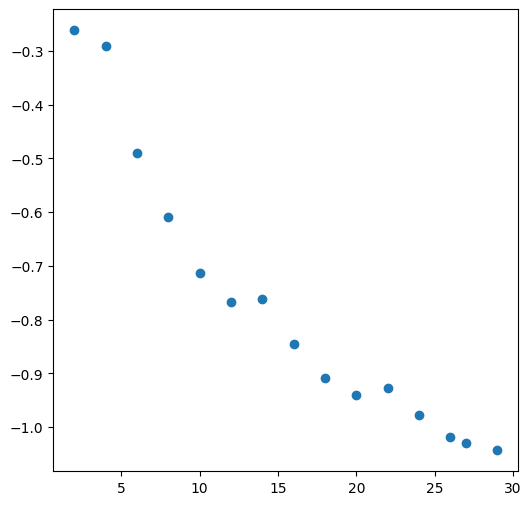

In [33]:
fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']

test_cluster_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

test_scores = []
for key in sorted_df_dict:
  df = sorted_df_dict[key]
  df_sum = df.iloc[:, 1:].sum().sum()
  sum_values_per_col = df.iloc[:, 1:].sum(axis=0)
  entropy = 0
  for i, col_sum in enumerate(sum_values_per_col[:1]):
    sr = df.iloc[:, i+1].divide(col_sum)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (col_sum/df_sum)
    entropy += col_entropy

  test_scores.append(entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, test_scores)


###Entropy score/One breakpoint

Optimal breakpoint 1: 10.000000000953937


/tmp/ipython-input-1262589709.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)


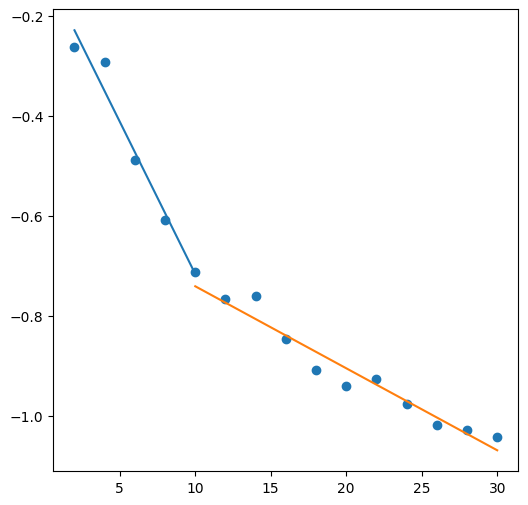

In [35]:

import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b, m1, c1, m2, c2):
  return np.where(x < b, m1 * x + c1, m2 * x + c2)

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint = None
  best_params = None
  potential_breakpoints = np.linspace(x[2], x[-2], num_breakpoints)

  for b_candidate in potential_breakpoints:
    try:
      # [breakpoint, slope1, intercept1, slope2, intercept2]
      initial_guess = [b_candidate, 1, 0, 0.5, 0.5]
      params, _ = curve_fit(piecewise_linear, x, y, p0=initial_guess)
      y_pred = piecewise_linear(x, *params)
      ssr = np.sum((y - y_pred)**2)

      if ssr < min_ssr:
        min_ssr = ssr
        best_breakpoint = params[0]
        best_params = params

    except RuntimeError:
      # Handle cases where curve_fit might fail to converge for a given breakpoint
      print('RuntimeError for case {}'.format(b_candidate))
      continue

  return best_breakpoint, best_params

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, m1, c1, m2, c2 = optimal_params

print('Optimal breakpoint 1:', optimal_b1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, max(x_data)], [m2*b1 + c2, m2*max(x_data) + c2])



In [ ]:
!pip install permetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.9 MB/s eta 0:00:00


{2:    LABEL  US_L3_13  US_L3_14  US_L3_18  US_L3_19  US_L3_20  US_L3_21  \
0      1    277994     72208       424      1211    107563       531   
1      2    167052      4213      4111     64628     41017     39124   

   US_L3_22  US_L3_23  US_L3_24  US_L3_25  US_L3_26  US_L3_5  US_L3_79  \
0    158698     15471     92041     18948     48917        0     31670   
1     39356    140483      8123     26773     52298     1398     22594   

   US_L3_80  US_L3_81  
0      7952    123796  
1     53807      1042  , 4:    LABEL  US_L3_13  US_L3_14  US_L3_18  US_L3_19  US_L3_20  US_L3_21  \
0      1    296787      2714       828      2295    106982       963   
1      2      7557     69132         0        16      3517         0   
2      3      3155      2099         0       168      2170      1079   
3      4    137547      2476      3707     63360     35911     37613   

   US_L3_22  US_L3_23  US_L3_24  US_L3_25  US_L3_26  US_L3_5  US_L3_79  \
0    150779      5259     24216         0    

/tmp/ipython-input-495697485.py:37: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-495697485.py:37: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


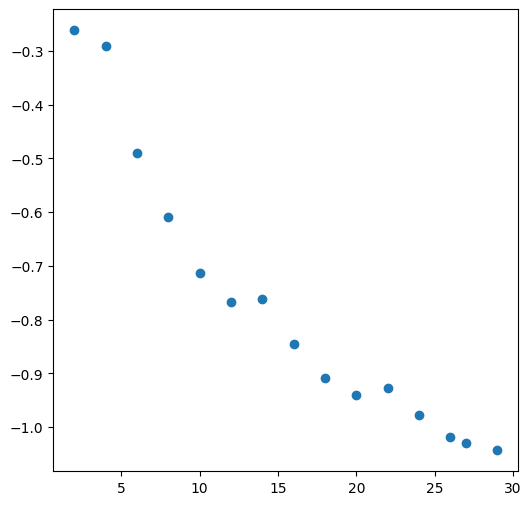

In [ ]:
import numpy as np
from permetrics import ClusteringMetric


fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']

df = pd.read_csv(os.path.join(fld, files[0]))

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_df_dict = {}
for key in keys:
  sorted_df_dict[key] = df_dict[key]

print(sorted_df_dict)

entropy_list = []
for key in sorted_df_dict:

  df = sorted_df_dict[key]
  df_sum = df.iloc[:, 1:].sum().sum()
  sum_values_per_col = df.iloc[:, 1:].sum(axis=0)
  entropy = 0
  for i, col_sum in enumerate(sum_values_per_col[:1]):
    sr = df.iloc[:, i+1].divide(col_sum)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (col_sum/df_sum)
    entropy += col_entropy

  entropy_list.append(entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, entropy_list)


